# Content

**Warning: <span style="color:red">high execution time (several hours) </span>**

Code below computes the model performance measures for the following input features:

    - Character Bi-grams
    - Character Tri-grams
    - Character 4-grams
    - Character 5-grams
    - Character 6-grams
    - Character 7-grams
    - Character 8-grams
    - Word Uni-gram
    - Word Bi-grams
    - Word Tri-grams

Code uses **Random Forest** and **Gradient Boosting** computed after *grid-search.*

In [1]:
# Import base libraries for mathematical operations, dataframes, time and plotting
import numpy as np
import pandas as pd
from time import time
import re
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve

from helper import preprocessor as pp
from helper import precisionmeasures as pm
from sklearn.metrics import average_precision_score


Using TensorFlow backend.


In [2]:
import helper
from helper import preprocessor as pp
from helper import precisionmeasures as pm

In [3]:
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 12, 8

In [4]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## 1. Data upload

In [5]:
class_names = ['Hate','Offensive','Neutral']

In [6]:
# upload the dataset
data = pp.load_data('labeled_data.csv')
max_length = 140
data['clean_tweet'] = data.tweet.apply(lambda doc: pp.clean_doc(doc))
# drop any rows with null (after preprocessing)
data = data.dropna()
# print first 5 rows of the data set
data.head()

,labels,category,tweet,clean_tweet
0,2,neutral,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house man alw...
1,1,offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe place
2,1,offensive,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit
3,1,offensive,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,1,offensive,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


In [7]:
# Split test and train data 
X_train, y_train= data.clean_tweet[:20000],data.labels[:20000]
X_test, y_test = data.clean_tweet[20000:],data.labels[20000:]
# One hot vectors for class labels
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

In [8]:
feature_list = ['char bi-gram','char tri-gram', 'char 4-gram',
                'char 5-gram', 'char 6-gram',
                'word uni-gram','word bi-gram','word tri-gram']

In [9]:
def feature_info(feature):
    ''' 
    Input: Feature
    Steps:
        Split each feature at whitespaces and hyphens and convert into lower case
        Set analyzer to 0th element of the split list 'char'/'word'
        Convert 1st element into numerical value
        Convert words like uni-1, bi-2, tri-3
    Output: analyzer = word/char
            N = range of N-grams
    '''
    token = re.split(r'\s|-', feature)
    analyzer = token[0]
    
    temp_dict = {'uni':1, 'bi': 2, 'tri': 3}
    
    if token[1] in temp_dict:
        N = temp_dict[token[1]]
    else:
        N = np.int(token[1])
    return (analyzer, N)

In [10]:
def performance_metrics_table(test,pred,feature):
    '''Inputs:
            test = actual labels of test set
            pred = model predictions for the the test set
            feature = feature name
            
            Computes macro- and micro- precision, recall and F1-score
        Output:
            Multi-index data frame with 3 precision measures 
    '''
    temp_dict = {'Performance':['Precision','Recall','F1-Score']}
    averages = ['micro','macro']
    for average in averages:
        p,r,f,_ = prfs(test,pred,average = average)
        temp_dict[average]= np.round((p,r,f),4)
    temp_df = pd.DataFrame(temp_dict)
    temp_df = pd.melt(temp_df, id_vars=['Performance'], value_vars=averages,
                        var_name='Metric', value_name=feature).set_index(['Metric','Performance'])
    temp_df = temp_df.rename_axis([None,'Performance Measures'])
    return temp_df

In [11]:
# For Each feature fit the decision tree models.
for i,feature in enumerate(feature_list): 
    print('Training Random Forests on: ',feature)
    # Extract infro from each feature  
    analyzer,N_range = feature_info(feature)
    # Vectorize the text data
    vectorizer = TfidfVectorizer(analyzer = analyzer,ngram_range = (N_range,N_range))
    x_train = vectorizer.fit_transform(X_train)
    x_test = vectorizer.transform(X_test)
    #########################################
    # Initiate Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=500, max_depth = 100,class_weight='balanced_subsample' )
    rf_clf.fit(x_train, y_train)
    y_pred_rf = rf_clf.predict(x_test)
    #########################################
    # Store the results from individual classifier per 
    if i==0:
        # Tables for storing performance metrics
        rf_tbl = performance_metrics_table(y_test,y_pred_rf,feature)
    else:
        # Join together tables for new features
        rf_tbl = rf_tbl.join(performance_metrics_table(y_test,y_pred_rf,feature))
        

print('=='*30)

Training Random Forests on:  char bi-gram
Training Random Forests on:  char tri-gram
Training Random Forests on:  char 4-gram
Training Random Forests on:  char 5-gram
Training Random Forests on:  char 6-gram
Training Random Forests on:  word uni-gram
Training Random Forests on:  word bi-gram
Training Random Forests on:  word tri-gram


In [12]:
#print performance metric table for Random Forests for the feature list
print('=='*22,'Random Forest Classifier','=='*22)
rf_tbl

============================================ Random Forest Classifier ============================================


char bi-gram  char tri-gram  char 4-gram  \
      Performance Measures                                             
micro Precision                   0.8808         0.9042       0.9080   
      Recall                      0.8808         0.9042       0.9080   
      F1-Score                    0.8808         0.9042       0.9080   
macro Precision                   0.7684         0.7222       0.7363   
      Recall                      0.5687         0.6567       0.7128   
      F1-Score                    0.5986         0.6618       0.7111   

                            char 5-gram  char 6-gram  word uni-gram  \
      Performance Measures                                            
micro Precision                  0.8873       0.8396         0.9030   
      Recall                     0.8873       0.8396         0.9030   
      F1-Score                   0.8873       0.8396         0.9030   
macro Precision                  0.7145       0.6691         0.7327   
      Recall                     0.7225       0.7063         0.7072   
      F1-Score                   0.7044       0.6642         0.7057   

                            word bi-gram  word tri-gram  
      Performance Measures                               
micro Precision                   0.4246         0.7966  
      Recall                      0.4246         0.7966  
      F1-Score                    0.4246         0.7966  
macro Precision                   0.5449         0.7654  
      Recall                      0.4640         0.3387  
      F1-Score                    0.3327         0.3063

In [13]:
# create new table for plotting
tbl = rf_tbl.reset_index()

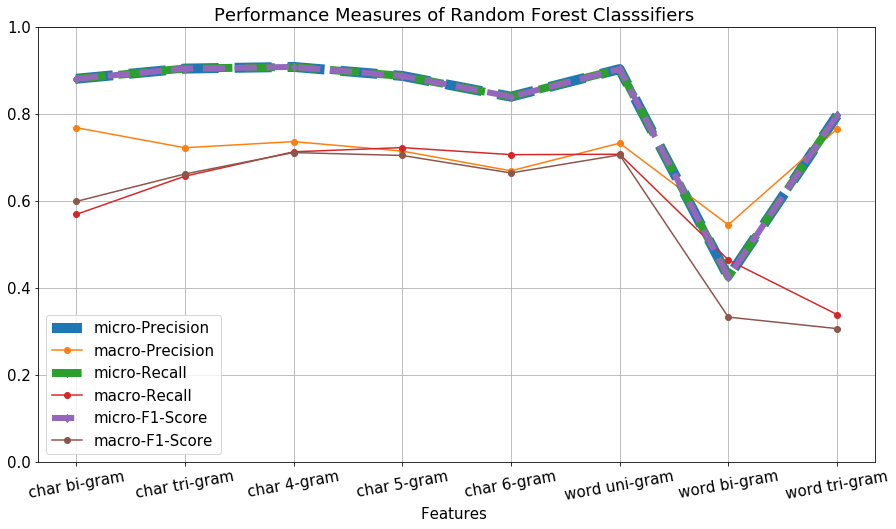

In [14]:
plt.figure(figsize = (15,8))
for i in range(3):
    plt.plot(np.arange(8),tbl.iloc[i,2:],marker = 'd',
             linestyle = '--',linewidth = 10-2*i,
             label = np.str(tbl.iloc[i,0])+'-'+np.str(tbl.iloc[i,1]))
    plt.plot(np.arange(8),tbl.iloc[i+3,2:],marker = 'o',
            label = np.str(tbl.iloc[i+3,0])+'-'+np.str(tbl.iloc[i+3,1]))
plt.legend()
plt.title('Performance Measures of Random Forest Classsifiers ')
plt.xlabel('Features ')
plt.xticks(np.arange(8),rf_tbl.columns, rotation = 10);
plt.ylim([0,1])
plt.grid()

In [19]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(X_train)
x_test = vectorizer.transform(X_test)
model = RandomForestClassifier(n_estimators=500, max_depth = 100,class_weight='balanced_subsample' )    
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_onehot = to_categorical(y_pred)
y_pred_prob = model.predict_proba(x_test)

In [20]:
print('='*10,'Classification Report','='*10)
cr = classification_report(y_test_onehot, y_pred_onehot,target_names=class_names,output_dict=True)
cr['Hate'].update({'PR_auc' : average_precision_score(y_test_onehot[:,0], y_pred_prob[:,0],average='micro')} )
cr['Offensive'].update({'PR_auc' : average_precision_score(y_test_onehot[:,1], y_pred_prob[:,1],average='micro')} )
cr['Neutral'].update({'PR_auc' : average_precision_score(y_test_onehot[:,2], y_pred_prob[:,2],average='micro')} )
cr['micro avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='micro')})
cr['macro avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='macro')})
cr['weighted avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='weighted')})
cr['samples avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='samples')})
score_matrix = pd.DataFrame.from_dict(cr).T
score_matrix

========== Classification Report ==========


,PR_auc,f1-score,precision,recall,support
Hate,0.341513,0.347578,0.491935,0.268722,227.0
Offensive,0.964799,0.943612,0.951820,0.935543,3801.0
Neutral,0.885285,0.829559,0.754063,0.921854,755.0
micro avg,0.941724,0.901735,0.901735,0.901735,4783.0
macro avg,0.730532,0.706916,0.732606,0.708707,4783.0
weighted avg,0.922666,0.897321,0.898778,0.901735,4783.0
samples avg,0.947766,0.901735,0.901735,0.901735,4783.0


Normalized confusion matrix
[[0.26872247 0.55947137 0.17180617]
 [0.01499605 0.93554328 0.04946067]
 [0.00794702 0.07019868 0.9218543 ]]
Average precision score, micro-averaged over all classes: 0.94


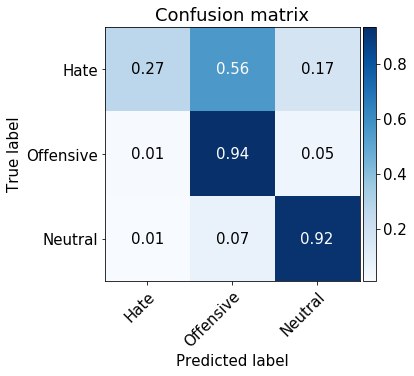

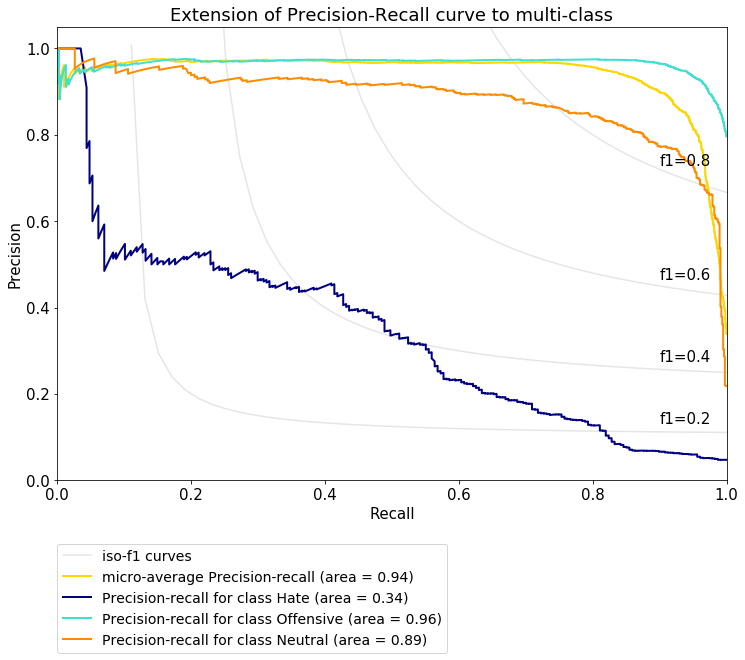

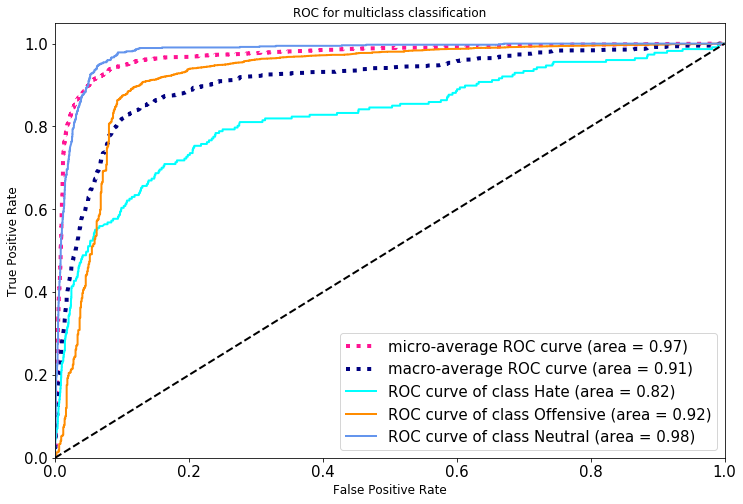

In [21]:
# Model confusion matrix
pm.plot_confusion_matrix(y_test.values, y_pred, classes=class_names,normalize = True,
                      title='Confusion matrix');
# Precision - Recall Curve
pm.prec_recall_curve(y_test_onehot, y_pred_prob,class_names)
# Reciever operator Curve
roc_auc = pm.ROC_curve(y_test_onehot, y_pred_prob,3)